<a href="https://colab.research.google.com/github/ibad321/Florence-2-Model-for-Cv-task/blob/main/florence_2_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q transformers accelerate timm flash_attn einops

In [ ]:
import cv2
import torch
import numpy as np
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)

In [ ]:
input_image= Image.open('/content/images.jpeg')
image_2= Image.open('/content/image2.jpg')


## CAPTION

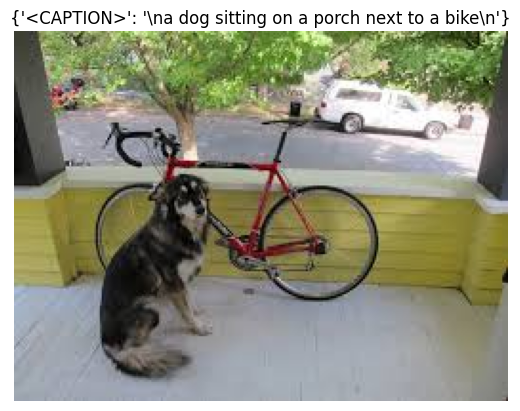

In [ ]:
task = '<CAPTION>'
inputs = processor(text=task, images=input_image, return_tensors="pt").to(device)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task=task, image_size=(input_image.width, input_image.height))
def display_image_with_caption(image, caption):
    plt.imshow(image)
    plt.title(caption)
    plt.axis("off")
    plt.show()

display_image_with_caption(input_image, parsed_answer)

## DETAILED_CAPTION

In [ ]:
task = '<DETAILED_CAPTION>'
inputs = processor(text=task, images=input_image, return_tensors="pt").to(device)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task=task, image_size=(input_image.width, input_image.height))

print(parsed_answer)


{'<DETAILED_CAPTION>': '\nThe image shows a dog sitting on the porch of a house, with a bicycle in front of it. In the background, there are trees and a car on the road.\n'}


## function

In [ ]:
def run_example(task_prompt, text_input=None, image=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

## MORE_DETAILED_CAPTION

In [ ]:
run_example(task_prompt='<MORE_DETAILED_CAPTION>',image=input_image)

{'<MORE_DETAILED_CAPTION>': '\nThe image shows a dog sitting on a porch with a red bicycle leaning against the wall. The dog is a mix of black, brown, and white fur, and it is looking directly at the camera with its ears perked up. The porch has a white floor and yellow walls, and there is a window on the right side of the image with a view of a street and trees outside. A white car can be seen driving on the road in the background.\n'}

## - Object detection

In [ ]:
task_prompt = '<OD>'
results = run_example(task_prompt,image=image_2)
print(results)

{'<OD>': {'bboxes': [[319.6000061035156, 10.25, 657.2000122070312, 208.25], [0.4000000059604645, 219.75, 754.0, 499.25], [78.80000305175781, 217.25, 232.40000915527344, 497.25], [686.0, 191.75, 786.0, 444.75], [654.0, 320.25, 725.2000122070312, 376.25], [516.4000244140625, 73.25, 655.6000366210938, 207.25], [322.0, 72.25, 453.20001220703125, 203.75], [478.8000183105469, 395.25, 612.4000244140625, 499.25], [43.60000228881836, 375.25, 146.0, 483.25], [380.3999938964844, 99.25, 489.20001220703125, 201.25]], 'labels': ['bicycle', 'car', 'person', 'person', 'taillight', 'wheel', 'wheel', 'wheel', 'wheel', 'wheel']}}


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

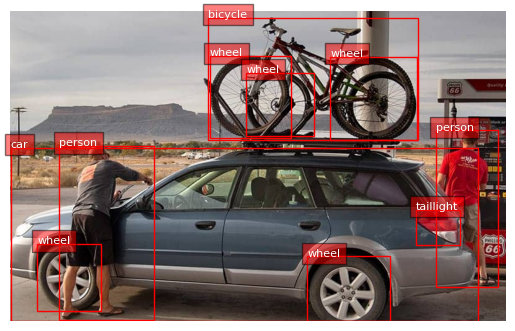

In [ ]:
plot_bbox(image_2, results['<OD>'])

## DENSE_REGION_CAPTION

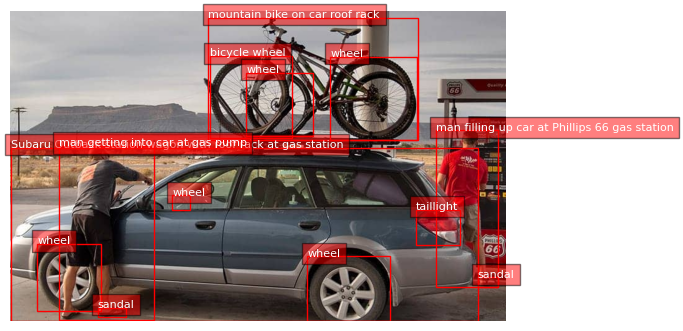

In [ ]:
task_prompt = '<DENSE_REGION_CAPTION>'
results = run_example(task_prompt,image=image_2)
plot_bbox(image_2, results['<DENSE_REGION_CAPTION>'])

## Segmentation

In [ ]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, text_input="cat",image=input_image)
results['<REFERRING_EXPRESSION_SEGMENTATION>']

{'polygons': [[[85.59950256347656,
    75.75700378417969,
    87.67150115966797,
    75.17500305175781,
    91.81549835205078,
    75.17500305175781,
    95.18250274658203,
    75.75700378417969,
    98.54949951171875,
    77.30900573730469,
    101.1395034790039,
    79.83100128173828,
    101.91650390625,
    81.77100372314453,
    101.91650390625,
    83.32300567626953,
    101.1395034790039,
    84.29299926757812,
    100.36250305175781,
    88.36700439453125,
    100.36250305175781,
    89.91900634765625,
    101.1395034790039,
    90.69499969482422,
    101.91650390625,
    95.9330062866211,
    101.91650390625,
    100.58900451660156,
    101.1395034790039,
    101.36500549316406,
    100.36250305175781,
    105.0510025024414,
    100.36250305175781,
    110.09500122070312,
    98.54949951171875,
    112.22900390625,
    98.54949951171875,
    121.92900085449219,
    97.77249908447266,
    124.83900451660156,
    96.99549865722656,
    126.39100646972656,
    95.18250274658203,


In [ ]:
results

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[85.59950256347656,
     75.75700378417969,
     87.67150115966797,
     75.17500305175781,
     91.81549835205078,
     75.17500305175781,
     95.18250274658203,
     75.75700378417969,
     98.54949951171875,
     77.30900573730469,
     101.1395034790039,
     79.83100128173828,
     101.91650390625,
     81.77100372314453,
     101.91650390625,
     83.32300567626953,
     101.1395034790039,
     84.29299926757812,
     100.36250305175781,
     88.36700439453125,
     100.36250305175781,
     89.91900634765625,
     101.1395034790039,
     90.69499969482422,
     101.91650390625,
     95.9330062866211,
     101.91650390625,
     100.58900451660156,
     101.1395034790039,
     101.36500549316406,
     100.36250305175781,
     105.0510025024414,
     100.36250305175781,
     110.09500122070312,
     98.54949951171875,
     112.22900390625,
     98.54949951171875,
     121.92900085449219,
     97.77249908447266,
     124.8390045

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):
    """
    Draws segmentation masks with polygons on an image.

    Parameters:
    - image_path: Path to the image file.
    - prediction: Dictionary containing 'polygons' and 'labels' keys.
                  'polygons' is a list of lists, each containing vertices of a polygon.
                  'labels' is a list of labels corresponding to each polygon.
    - fill_mask: Boolean indicating whether to fill the polygons with color.
    """
    # Load the image

    draw = ImageDraw.Draw(image)


    # Set up scale factor if needed (use 1 if not scaling)
    scale = 1

    # Iterate over polygons and labels
    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        color = random.choice(colormap)
        fill_color = random.choice(colormap) if fill_mask else None

        for _polygon in polygons:
            _polygon = np.array(_polygon).reshape(-1, 2)
            if len(_polygon) < 3:
                print('Invalid polygon:', _polygon)
                continue

            _polygon = (_polygon * scale).reshape(-1).tolist()

            # Draw the polygon
            if fill_mask:
                draw.polygon(_polygon, outline=color, fill=fill_color)
            else:
                draw.polygon(_polygon, outline=color)

            # Draw the label text
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)

    # Save or display the image
    #image.show()  # Display the image
    display(image)

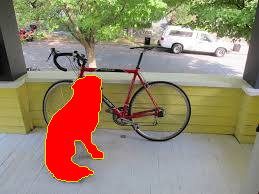

In [ ]:
import copy
output_image = copy.deepcopy(input_image)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)

## Text detection

In [ ]:
text = Image.open('/content/text.jpg')

In [ ]:
task_prompt = ''
run_example(task_prompt,image=text)

{'': '\na resume template with a white background and black text<loc_0><loc_0><loc_998><loc_998>\n'}

In [ ]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt,image=text)
print(results)

{'<OCR_WITH_REGION>': {'quad_boxes': [[89.63500213623047, 95.67250061035156, 418.14501953125, 95.67250061035156, 418.14501953125, 115.19750213623047, 89.63500213623047, 115.19750213623047], [565.5650024414062, 194.07850646972656, 693.875, 194.07850646972656, 693.875, 216.72750854492188, 565.5650024414062, 216.72750854492188], [89.63500213623047, 241.71951293945312, 525.5250244140625, 241.71951293945312, 525.5250244140625, 260.4635009765625, 89.63500213623047, 260.4635009765625], [586.4949951171875, 240.15750122070312, 802.1650390625, 240.93850708007812, 802.1650390625, 260.4635009765625, 586.4949951171875, 259.6824951171875], [89.63500213623047, 269.83551025390625, 500.95501708984375, 269.83551025390625, 500.95501708984375, 285.45550537109375, 89.63500213623047, 285.45550537109375], [586.4949951171875, 268.27349853515625, 804.89501953125, 269.05450439453125, 804.89501953125, 284.67449951171875, 586.4949951171875, 283.89349365234375], [586.4949951171875, 287.7984924316406, 799.434997558

In [ ]:
def draw_ocr_bboxes(image, prediction):
    scale = 1
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",

                    fill=color)
    display(image)

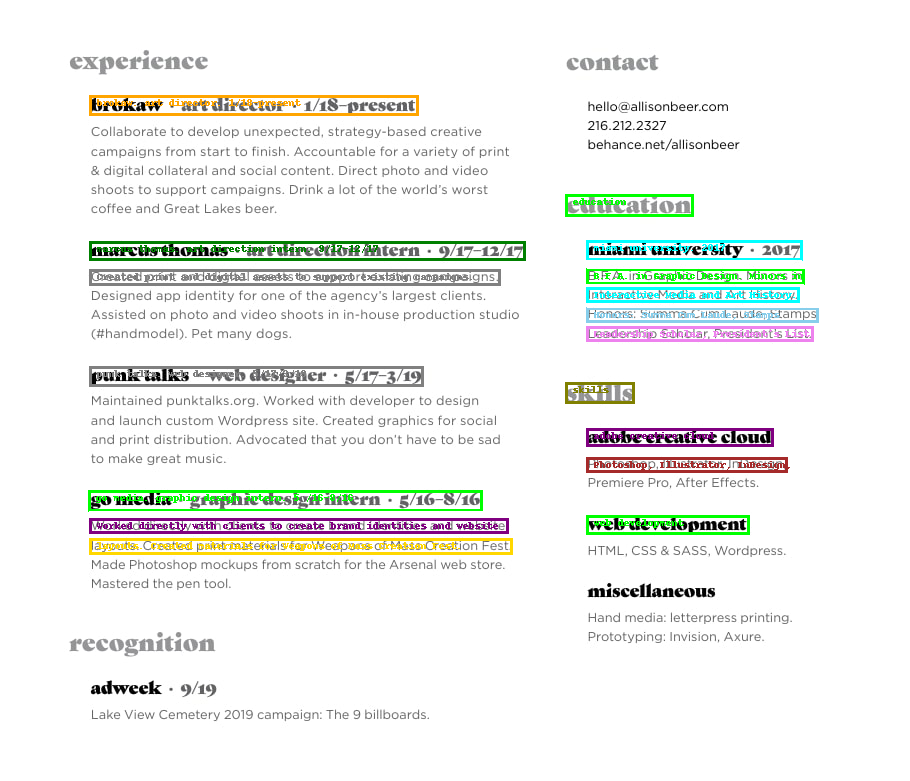

In [ ]:
output_image = copy.deepcopy(text)
draw_ocr_bboxes(output_image, results['<OCR_WITH_REGION>'])

## Funciona  video

In [ ]:
# video
video_path = '/content/traffic-mini.mp4'
output_path = '/content/output.mp4'
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec para el archivo de salida
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

prompt = "<OD>"
frame_count = 0

# Variables to store detections from the last processed frame
last_bboxes = []
last_labels = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Render only every 10 frames
    if frame_count % 10 == 0:
        #Convert the frame to a PIL image
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Process the image with Florence-2
        inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3,
            do_sample=False
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))

        #Update detections from the last processed frame
        last_bboxes = parsed_answer['<OD>']['bboxes']
        last_labels = parsed_answer['<OD>']['labels']

    #Draw detection boxes and labels on the frame using the last processed detection
    for bbox, label in zip(last_bboxes, last_labels):
        x1, y1, x2, y2 = [int(coord) for coord in bbox]
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    #Write the processed frame to the output file
    out.write(frame)
    frame_count += 1

cap.release()
out.release()
print(f"Processed {frame_count // 10} frames and saved to {output_path}")

Processed 17 frames and saved to /content/output.mp4
